# Analysis for Figure3

In [1]:
1

1

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import scanpy.external as sce
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import rapids_singlecell as rsc
import scanpy as sc
import cupyx as cpx
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scib
import scib_metrics

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_na

CUDA used: True


In [4]:
!ls /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed

cpa_GSM_new.h5ad		 dataset_complete_To.h5ad
cpa_kang.h5ad			 dataset_complete_Wang.h5ad
cpa_Norman2019_prep_new.h5ad	 dataset_complete_Yu.h5ad
dataset_complete_Braun.h5ad	 dataset_complete_Zhang.h5ad
dataset_complete_Calvanese.h5ad  dataset_subset_age_1.h5ad
dataset_complete_Colin.h5ad	 dataset_subset_age_2.h5ad
dataset_complete_Dong.h5ad	 dataset_subset_age_3.h5ad
dataset_complete_Garcia.h5ad	 dataset_subset_age_4.h5ad
dataset_complete_He.h5ad	 dataset_subset_age_sex_1.h5ad
dataset_complete_Kanemaru.h5ad	 dataset_subset_biological_unit_1.h5ad
dataset_complete_Lawrence.h5ad	 dataset_subset_sample_status_1.h5ad
dataset_complete_Miller.h5ad	 dataset_subset_sex_1.h5ad
dataset_complete_Sridhar.h5ad	 dataset_subset_sex_2.h5ad
dataset_complete_Suo.h5ad


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Suo.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

In [6]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "suo_age-continuous"
)
vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/suo_age-continuous/model.pt already    
         downloaded                                                                                                


CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
adata.obs["age_continuous"] = adata.obs["age"].astype(float)

In [9]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(adata=latent, n_neighbors = 30)
rsc.tl.umap(adata=latent)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/cupy/sparse/__init__.py:17: DeprecationWarning: cupy.sparse is deprecated. Use cupyx.scipy.sparse instead.
  warnings.warn(msg, DeprecationWarning)


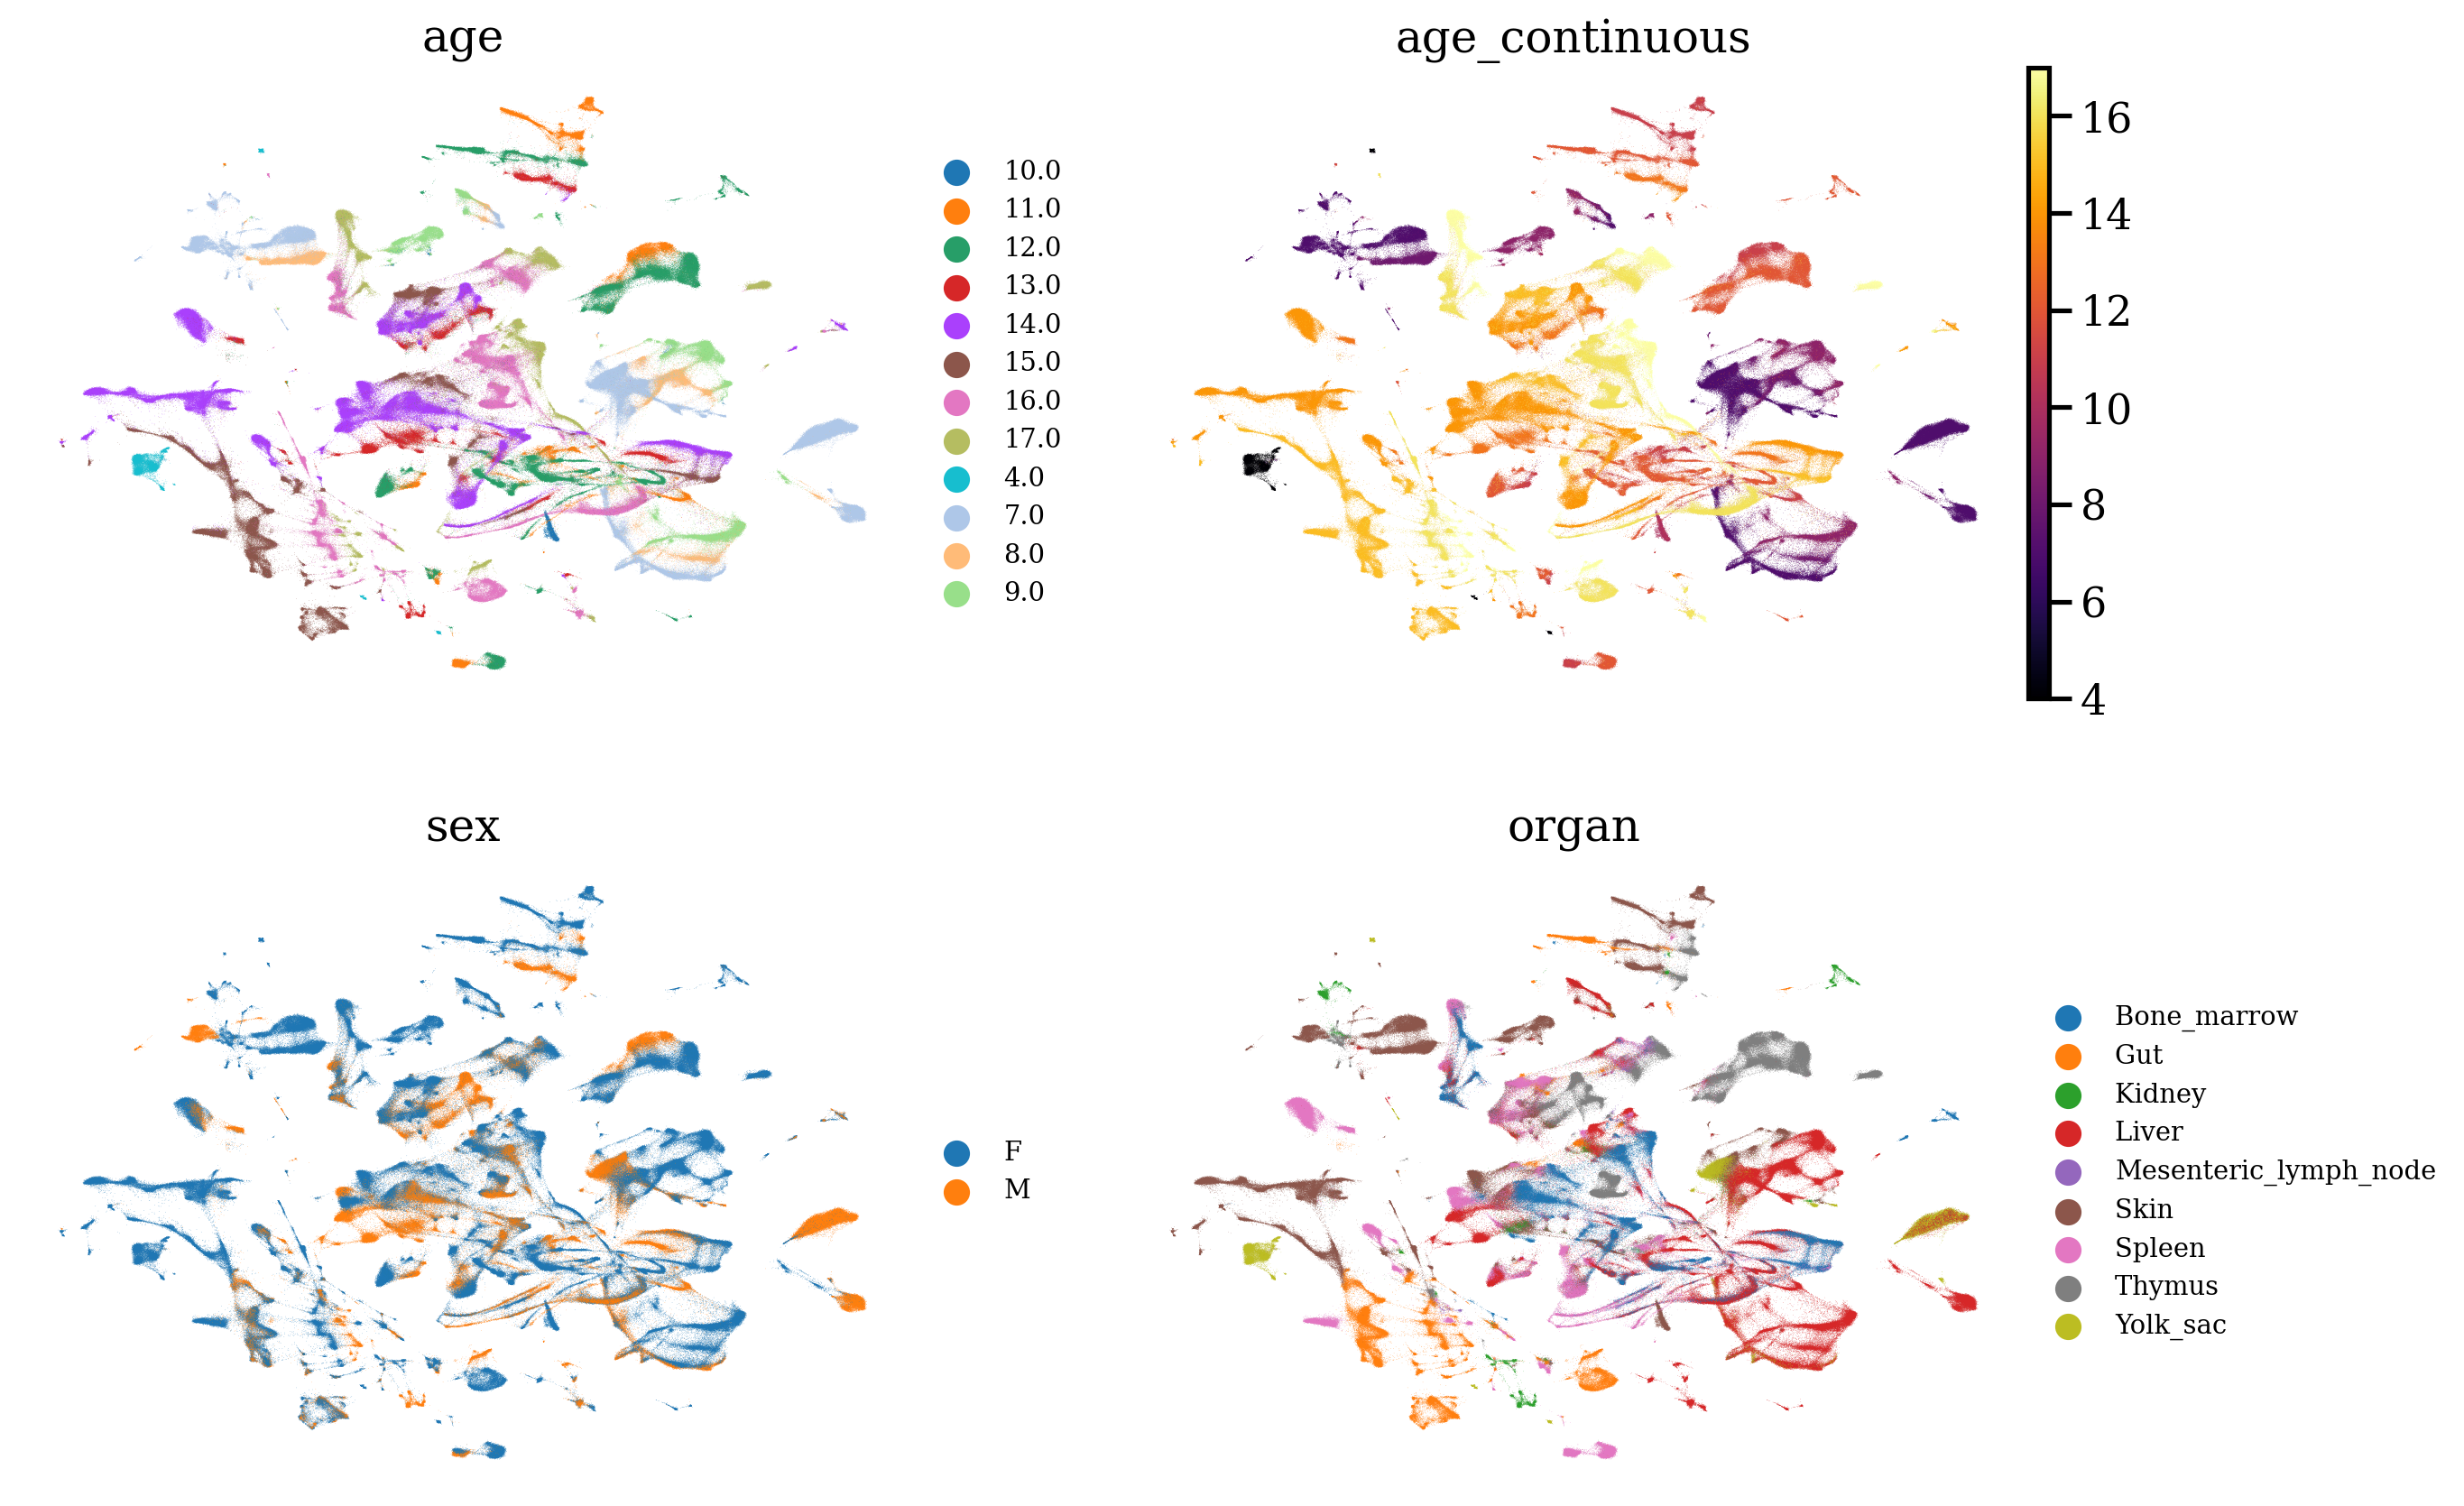

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["age", "age_continuous", "sex", "organ"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [15]:
from tardis._disentanglementmanager import DisentanglementManager

In [17]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(adata=latent, n_neighbors = 30)
rsc.tl.umap(adata=latent)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/cupy/sparse/__init__.py:17: DeprecationWarning: cupy.sparse is deprecated. Use cupyx.scipy.sparse instead.
  warnings.warn(msg, DeprecationWarning)


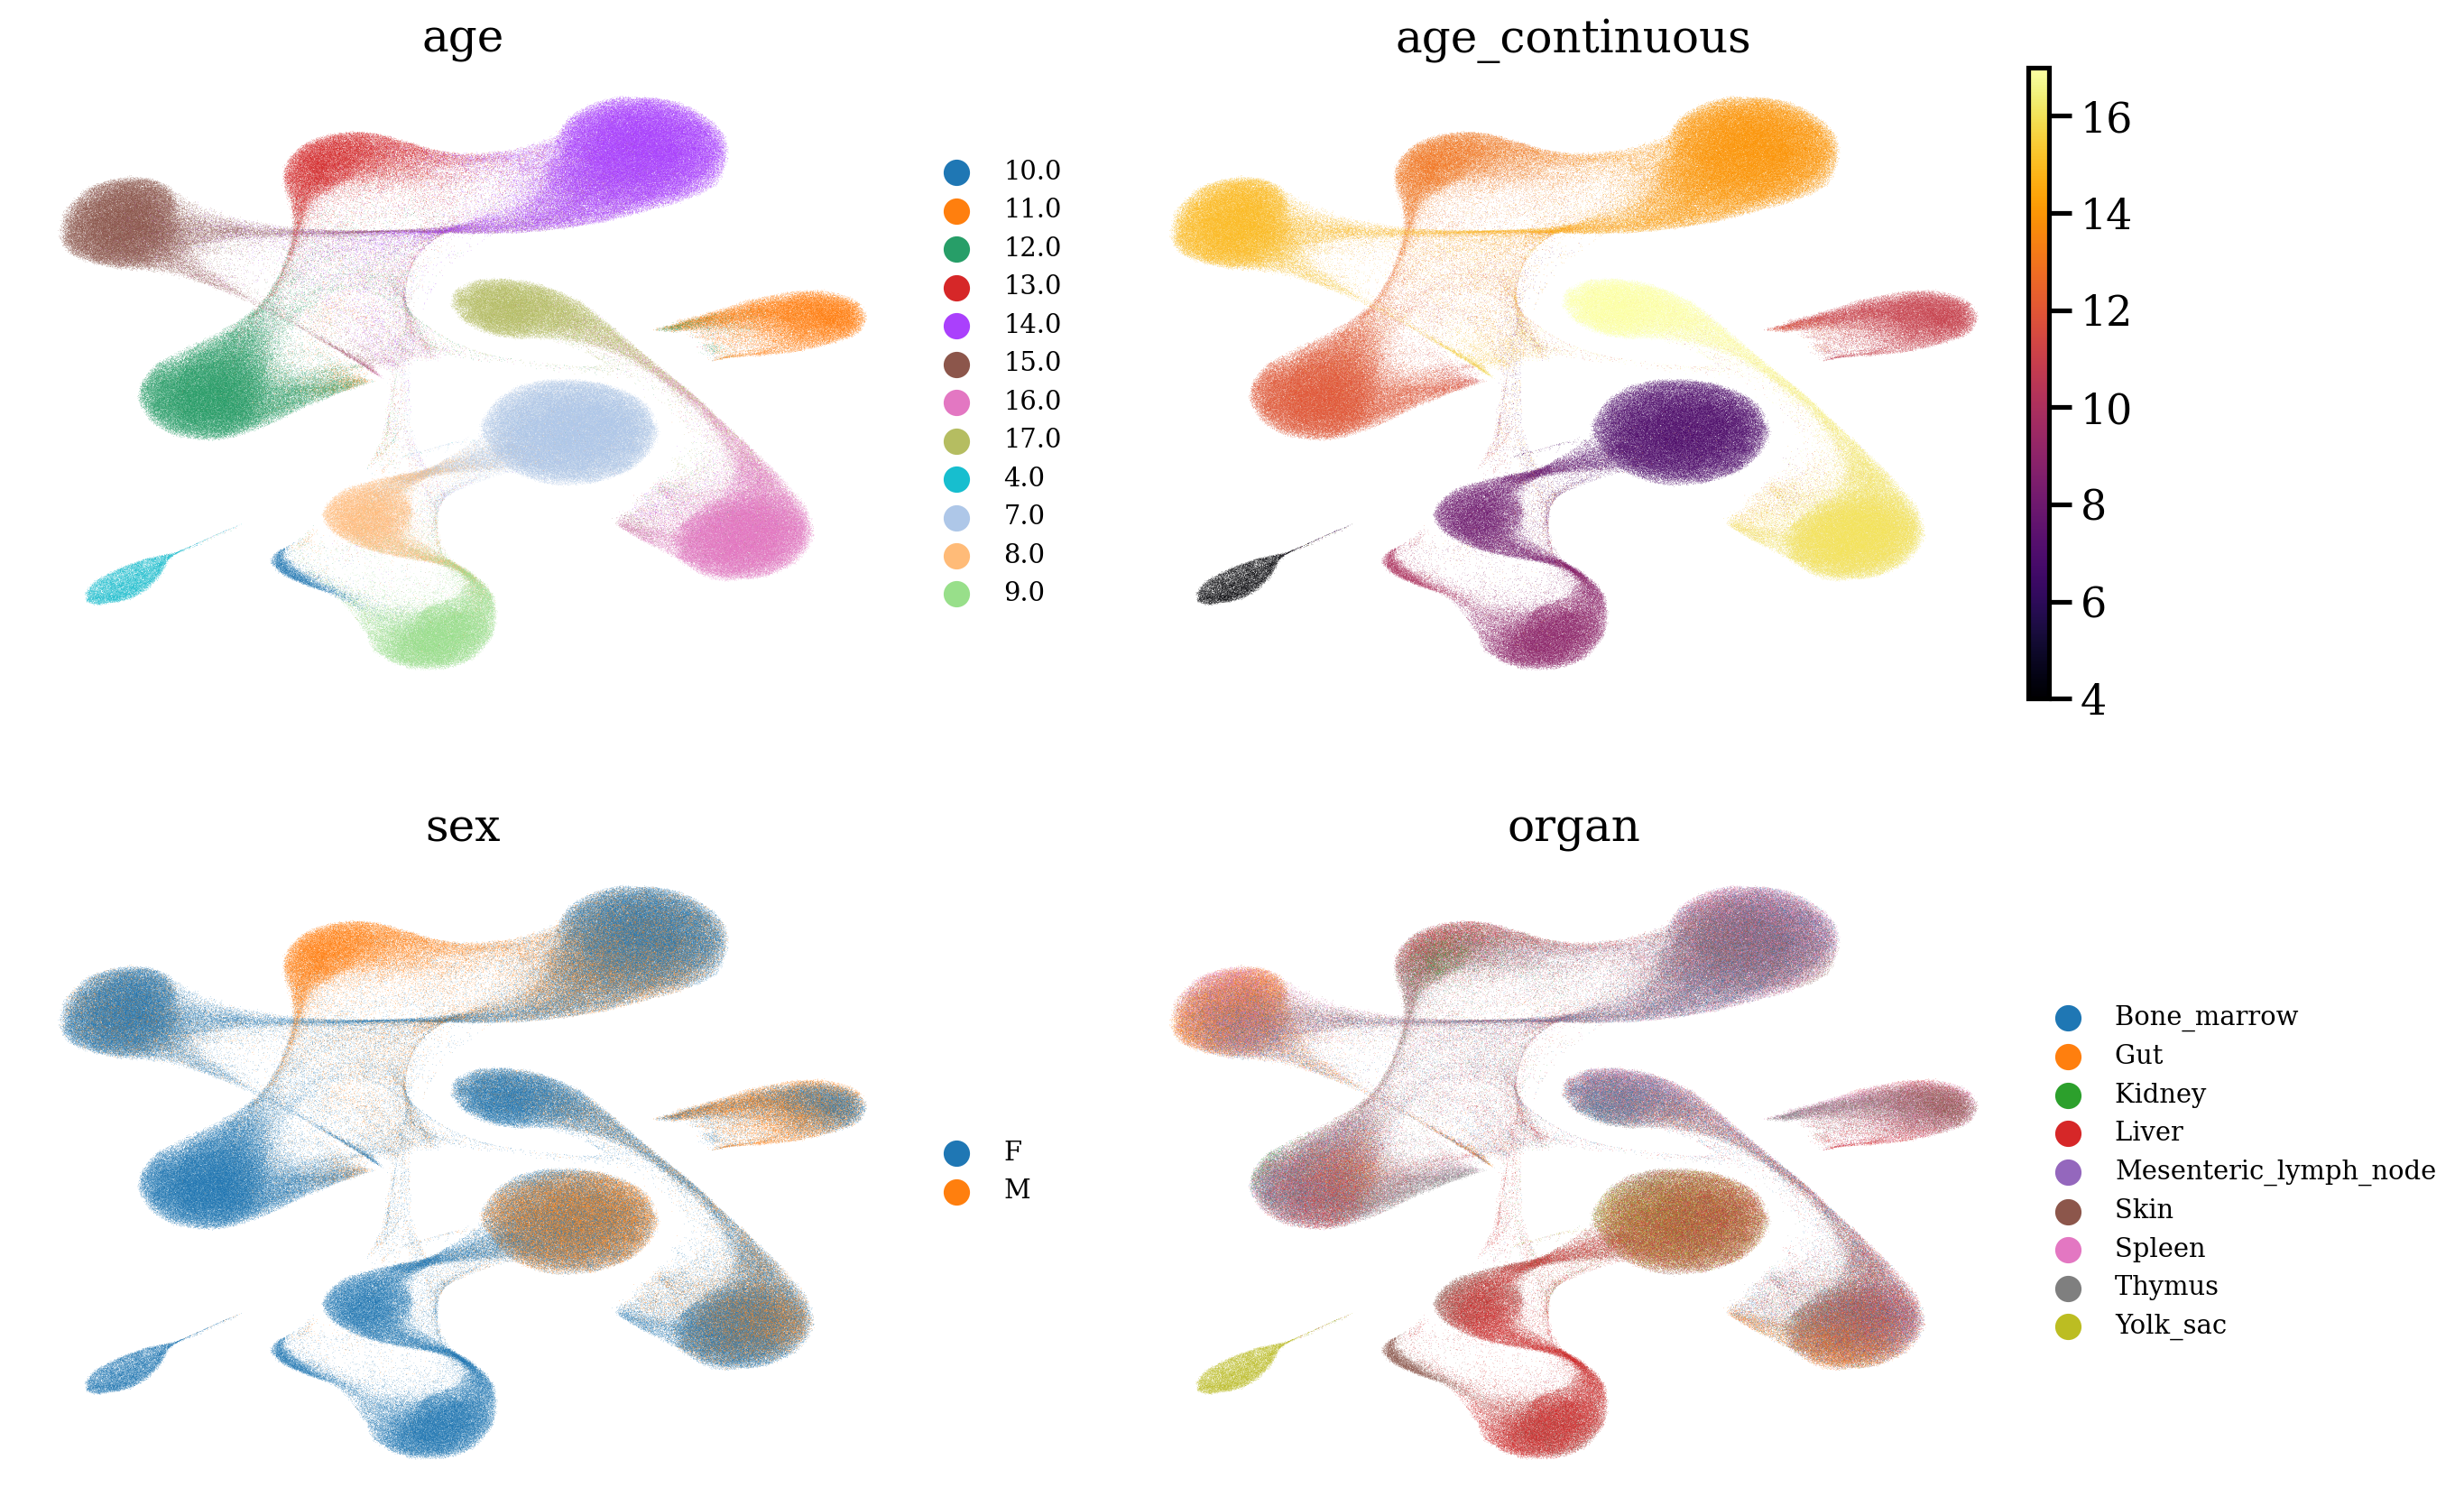

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["age", "age_continuous", "sex", "organ"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [32]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.tl.pca(latent, n_comps=7)

computing PCA
    with n_comps=7
    finished (0:00:00)


In [24]:
import palantir

In [33]:
dm_res = palantir.utils.run_diffusion_maps(latent, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(latent)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:23)


In [34]:
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(adata=latent, n_neighbors = 30)
rsc.tl.umap(adata=latent)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/cupy/sparse/__init__.py:17: DeprecationWarning: cupy.sparse is deprecated. Use cupyx.scipy.sparse instead.
  warnings.warn(msg, DeprecationWarning)


In [35]:
start_cell = latent.obs.index[np.where([latent.obs["age_continuous"] == latent.obs["age_continuous"].min()])[1]][20]
end_cell = latent.obs.index[np.where([latent.obs["age_continuous"] == latent.obs["age_continuous"].max()])[1]][0]

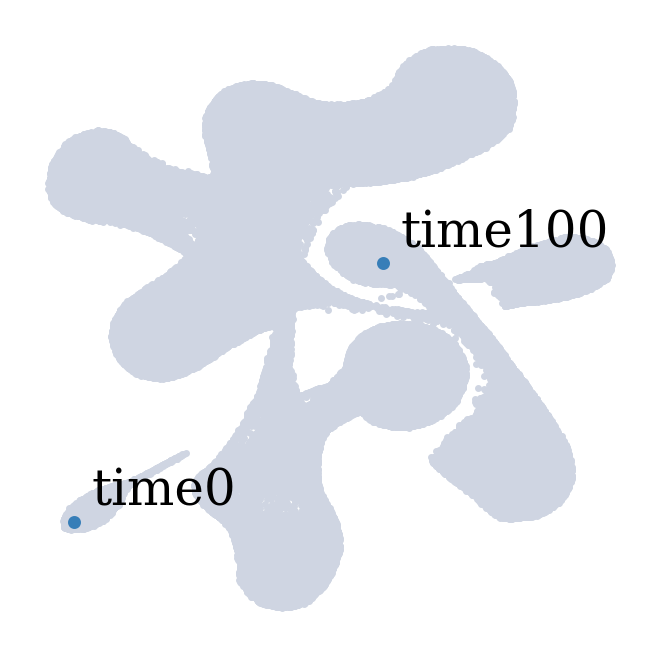

In [36]:
terminal_states = pd.Series(
    ["time0", "time100"],
    index=[start_cell, end_cell],
)

palantir.plot.highlight_cells_on_umap(latent, terminal_states)
plt.show()

(<Figure size 1500x300 with 5 Axes>,
 {0: <Axes: title={'center': 'Component 0'}>,
  1: <Axes: title={'center': 'Component 1'}>,
  2: <Axes: title={'center': 'Component 2'}>,
  3: <Axes: title={'center': 'Component 3'}>,
  4: <Axes: title={'center': 'Component 4'}>})

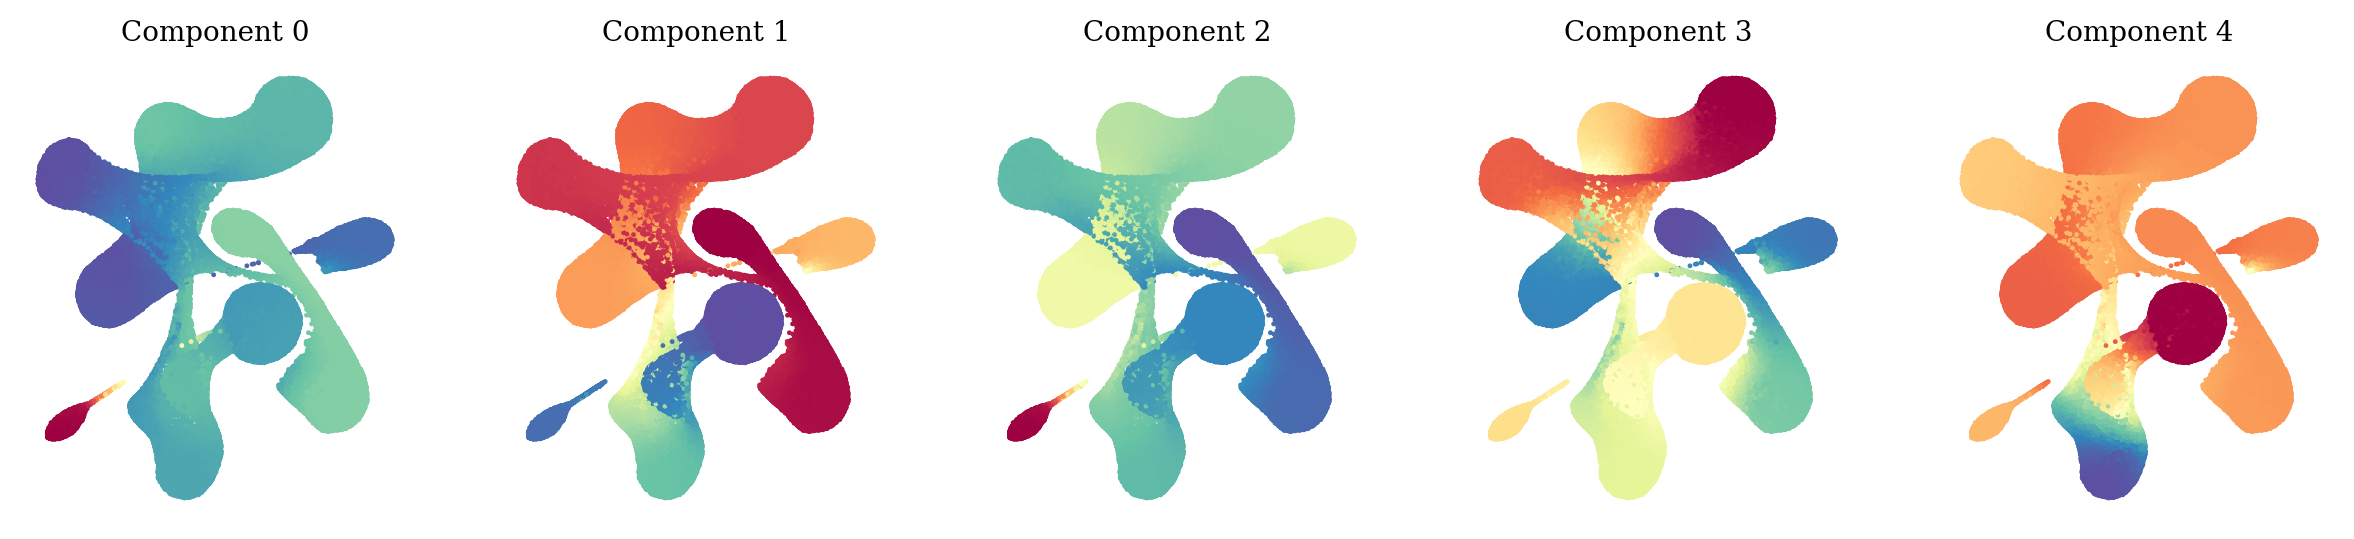

In [37]:
palantir.plot.plot_diffusion_components(latent)

In [38]:
pr_res = palantir.core.run_palantir(
    latent, start_cell, knn=15, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 4.747565670808156 minutes
Determining pseudotime...
Shortest path distances using 15-nearest neighbor graph...


KeyboardInterrupt: 

In [ ]:
palantir.plot.plot_palantir_results(latent, s=2)
plt.show()